# Recommendation System using MiniBatchKMeans


In [17]:
#Import necessary libraries
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import networkx as nx
import time
import math
import nltk
nltk.download('stopwords')

# Analysing the input dataframe
df = pd.read_csv("netflix_titles.csv")
netflix = df.copy()
netflix = netflix.sort_values(by='title', ascending=True)

# mapping the multiple value cells into list type
df["directors"] = df["director"].apply(
    lambda l: [] if pd.isna(l) else [i.strip().replace(" ", "_") for i in l.split(",")]
)
df["genres"] = df["listed_in"].apply(
    lambda l: [] if pd.isna(l) else [i.strip().replace(" ", "_") for i in l.split(",")]
)
df["actors"] = df["cast"].apply(
    lambda l: [] if pd.isna(l) else [i.strip().replace(" ", "_") for i in l.split(",")]
)
df["countries"] = df["country"].apply(
    lambda l: [] if pd.isna(l) else [i.strip().replace(" ", "_") for i in l.split(",")]
)
df["all_features"] = df["directors"] + df["genres"] + df["actors"] + df["countries"]
df["all_features"] = df["all_features"].apply(lambda x: " ".join(x))

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def text_cleanser(text):
    stemmer = WordNetLemmatizer()
    text = "".join(
        [char for char in text if (char.isalpha() or char.isspace()) and char != "'"]
    )
    text = [
        word.lower()
        for word in text.split()
        if word.lower() not in stopwords.words("english")
    ]
    return [stemmer.lemmatize(word) for word in text]

df_desc = df[["show_id", "description"]].set_index("show_id")
df_desc["trunc_desc"] = df_desc["description"].apply(lambda x: text_cleanser(x))

vocabulary = {}
for words in df_desc.trunc_desc:
    for word in words:
        if word in vocabulary:
            vocabulary[word] = vocabulary[word] + 1
        else:
            vocabulary[word] = 1
df_voc = pd.DataFrame(list(vocabulary.items()), columns=["text", "count"])


[nltk_data] Downloading package stopwords to /Users/code/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Clustering :-


In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

bow_transformer = CountVectorizer(analyzer=text_cleanser).fit(df_desc["description"])
desc_bow = bow_transformer.transform(df_desc["description"])
print("Shape of the generated matrix : ", desc_bow.shape)
sparsity = desc_bow.nnz / (desc_bow.shape[0] * desc_bow.shape[1]) * 100.0
print("Sparsity of the generated matrix", round(sparsity, 4))

# Finding TF and IDF metrics
vector = TfidfVectorizer(
    max_df=1,
    min_df=1,
    strip_accents="ascii",
    stop_words="english",
    lowercase=True,
    use_idf=True,
    norm="l2",
    smooth_idf=True,
)
tfidf = vector.fit_transform(df.all_features)

# Cluster the description data using MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import linear_kernel

# setting the no. of resulting clusters for kmeans
k = 1000
kmeans = MiniBatchKMeans(n_clusters=k, init="k-means++")
kmeans.fit(tfidf)
centers = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vector.get_feature_names_out()
request_transform = vector.transform(df["all_features"])
# new column cluster based on the description
df["cluster"] = kmeans.predict(request_transform)

def find_similar_movies(tfidf_matrix, index, top_n=5):
    cosine_similarities = linear_kernel(
        tfidf_matrix[index : index + 1], tfidf_matrix
    ).flatten()
    related_docs_indices = [
        i for i in cosine_similarities.argsort()[::-1] if i != index
    ]
    return [index for index in related_docs_indices][0:top_n]


Shape of the generated matrix :  (8807, 18085)
Sparsity of the generated matrix 0.079


/Users/code/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Graph preparation

- Inserts all the notable parameters like castings,genre and directors as nodes in the graph.
- Find_similar_movies() method to fetch the n related movies for the given node
- Connect the all the related movie nodes with the selected movie with an edge names 'SIMILAR'


In [25]:
G = nx.Graph(label="MOVIE")
start_time = time.time()
for i, rowi in df.iterrows():
    G.add_node(
        rowi["title"],
        key=rowi["show_id"],
        label="MOVIE",
        mtype=rowi["type"],
        rating=rowi["rating"],
    )
    for element in rowi["actors"]:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi["title"], element, label="ACTED_IN")
    for element in rowi["genres"]:
        G.add_node(element, label="GENRE")
        G.add_edge(rowi["title"], element, label="GENRE_IN")
    for element in rowi["directors"]:
        G.add_node(element, label="PERSON")
        G.add_edge(rowi["title"], element, label="DIRECTED")
    for element in rowi["countries"]:
        G.add_node(element, label="COU")
        G.add_edge(rowi["title"], element, label="COU_IN")

    indices = find_similar_movies(tfidf, i, top_n=3)
    snode = "Sim(" + rowi["title"][:15].strip() + ")"
    G.add_node(snode, label="SIMILAR")
    G.add_edge(rowi["title"], snode, label="SIMILARITY")
    for element in indices:
        G.add_edge(snode, df["title"].loc[element], label="SIMILARITY")
print(" finish -- {} seconds --".format(time.time() - start_time))

def get_all_adj_nodes(list_in):
    sub_graph = set()
    for m in list_in:
        sub_graph.add(m)
        for e in G.neighbors(m):
            sub_graph.add(e)
    return list(sub_graph)


def draw_sub_graph(sub_graph, title=""):
    subgraph = G.subgraph(sub_graph)
    colors = []
    sizes = []
    std_size = 500
    for e in subgraph.nodes():
        if G.nodes[e]["label"] == "MOVIE":
            colors.append("#b3042c")
            sizes.append(std_size * 5)
        elif G.nodes[e]["label"] == "PERSON":
            colors.append("#047d59")
            sizes.append(std_size * 2.5)
        elif G.nodes[e]["label"] == "GENRE":
            colors.append("#3a018a")
            sizes.append(std_size)
        elif G.nodes[e]["label"] == "COU":
            colors.append("#bd3102")
            sizes.append(std_size * 0.9)
        elif G.nodes[e]["label"] == "SIMILAR":
            colors.append("#b87906")
            sizes.append(std_size)
        elif G.nodes[e]["label"] == "CLUSTER":
            colors.append("#cdf7e9")
            sizes.append(std_size * 0.9)
    fig, ax = plt.subplots(figsize=(18, 18))
    nx.draw(
        subgraph,
        with_labels=True,
        alpha=0.8,
        node_shape="o",
        node_size=sizes,
        cmap="Accent",
        edge_color="white",
        font_color="white",
        font_weight="bold",
        node_color=colors,
    )
    # plt.title('Recommendations after watching The video '+title+' :-')
    ax.set_title("Recommendations for Movie " + title + " :-", color="white", size=30)
    ax.axis("off")
    fig.set_facecolor("#828282")
    plt.tight_layout()
    plt.gcf().set_dpi(300)
    plt.show()

 finish -- 7.039586067199707 seconds --


In [26]:
def get_recommendation(root):
    commons_dict = {}
    for e in G.neighbors(root):
        for e2 in G.neighbors(e):
            if e2 == root:
                continue
            if G.nodes[e2]["label"] == "MOVIE":
                commons = commons_dict.get(e2)
                if commons == None:
                    commons_dict.update({e2: [e]})
                else:
                    commons.append(e)
                    commons_dict.update({e2: commons})
    movies = []
    weight = []
    for key, values in commons_dict.items():
        w = 0.0
        for e in values:
            w = w + 1 / math.log(G.degree(e))
        movies.append(key)
        weight.append(w)

    result = pd.Series(data=np.array(weight), index=movies)
    result.sort_values(inplace=True, ascending=False)
    return result

import ipywidgets as widgets
from IPython.display import display

# Assuming 'title' is the column in the 'netflix' dataframe that contains the movie names
# Assuming 'release_year' is the column in the 'netflix' dataframe that contains the release years
year_list = ['All Years'] + sorted(netflix['release_year'].unique().tolist())

dropdown_movie = widgets.Dropdown(
    description = 'Movies:',
    disabled = False,
)

dropdown_year = widgets.Dropdown(
    options = year_list,
    description = 'Year:',
    disabled = False,
)

def update_movies(*args):
    selected_year = dropdown_year.value
    if selected_year == 'All Years':
        # If 'All Years' is selected, show all movies
        filtered_movies = netflix['title'].unique().tolist()
    else:
        # Filter the movies based on the selected year
        filtered_movies = netflix[netflix['release_year'] == selected_year]['title'].unique().tolist()
    dropdown_movie.options = filtered_movies

def on_change_movie(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global selected_movie
        selected_movie = change['new']
        print(f"Selected Movie: {selected_movie}")

dropdown_year.observe(update_movies, 'value')
dropdown_movie.observe(on_change_movie, 'value')

display(dropdown_year, dropdown_movie)


Dropdown(description='Year:', options=('All Years', 1925, 1942, 1943, 1944, 1945, 1946, 1947, 1954, 1955, 1956…

Dropdown(description='Movies:', options=(), value=None)

Selected Movie: #Alive
Selected Movie: Midnight Mass
Selected Movie: Men in Black


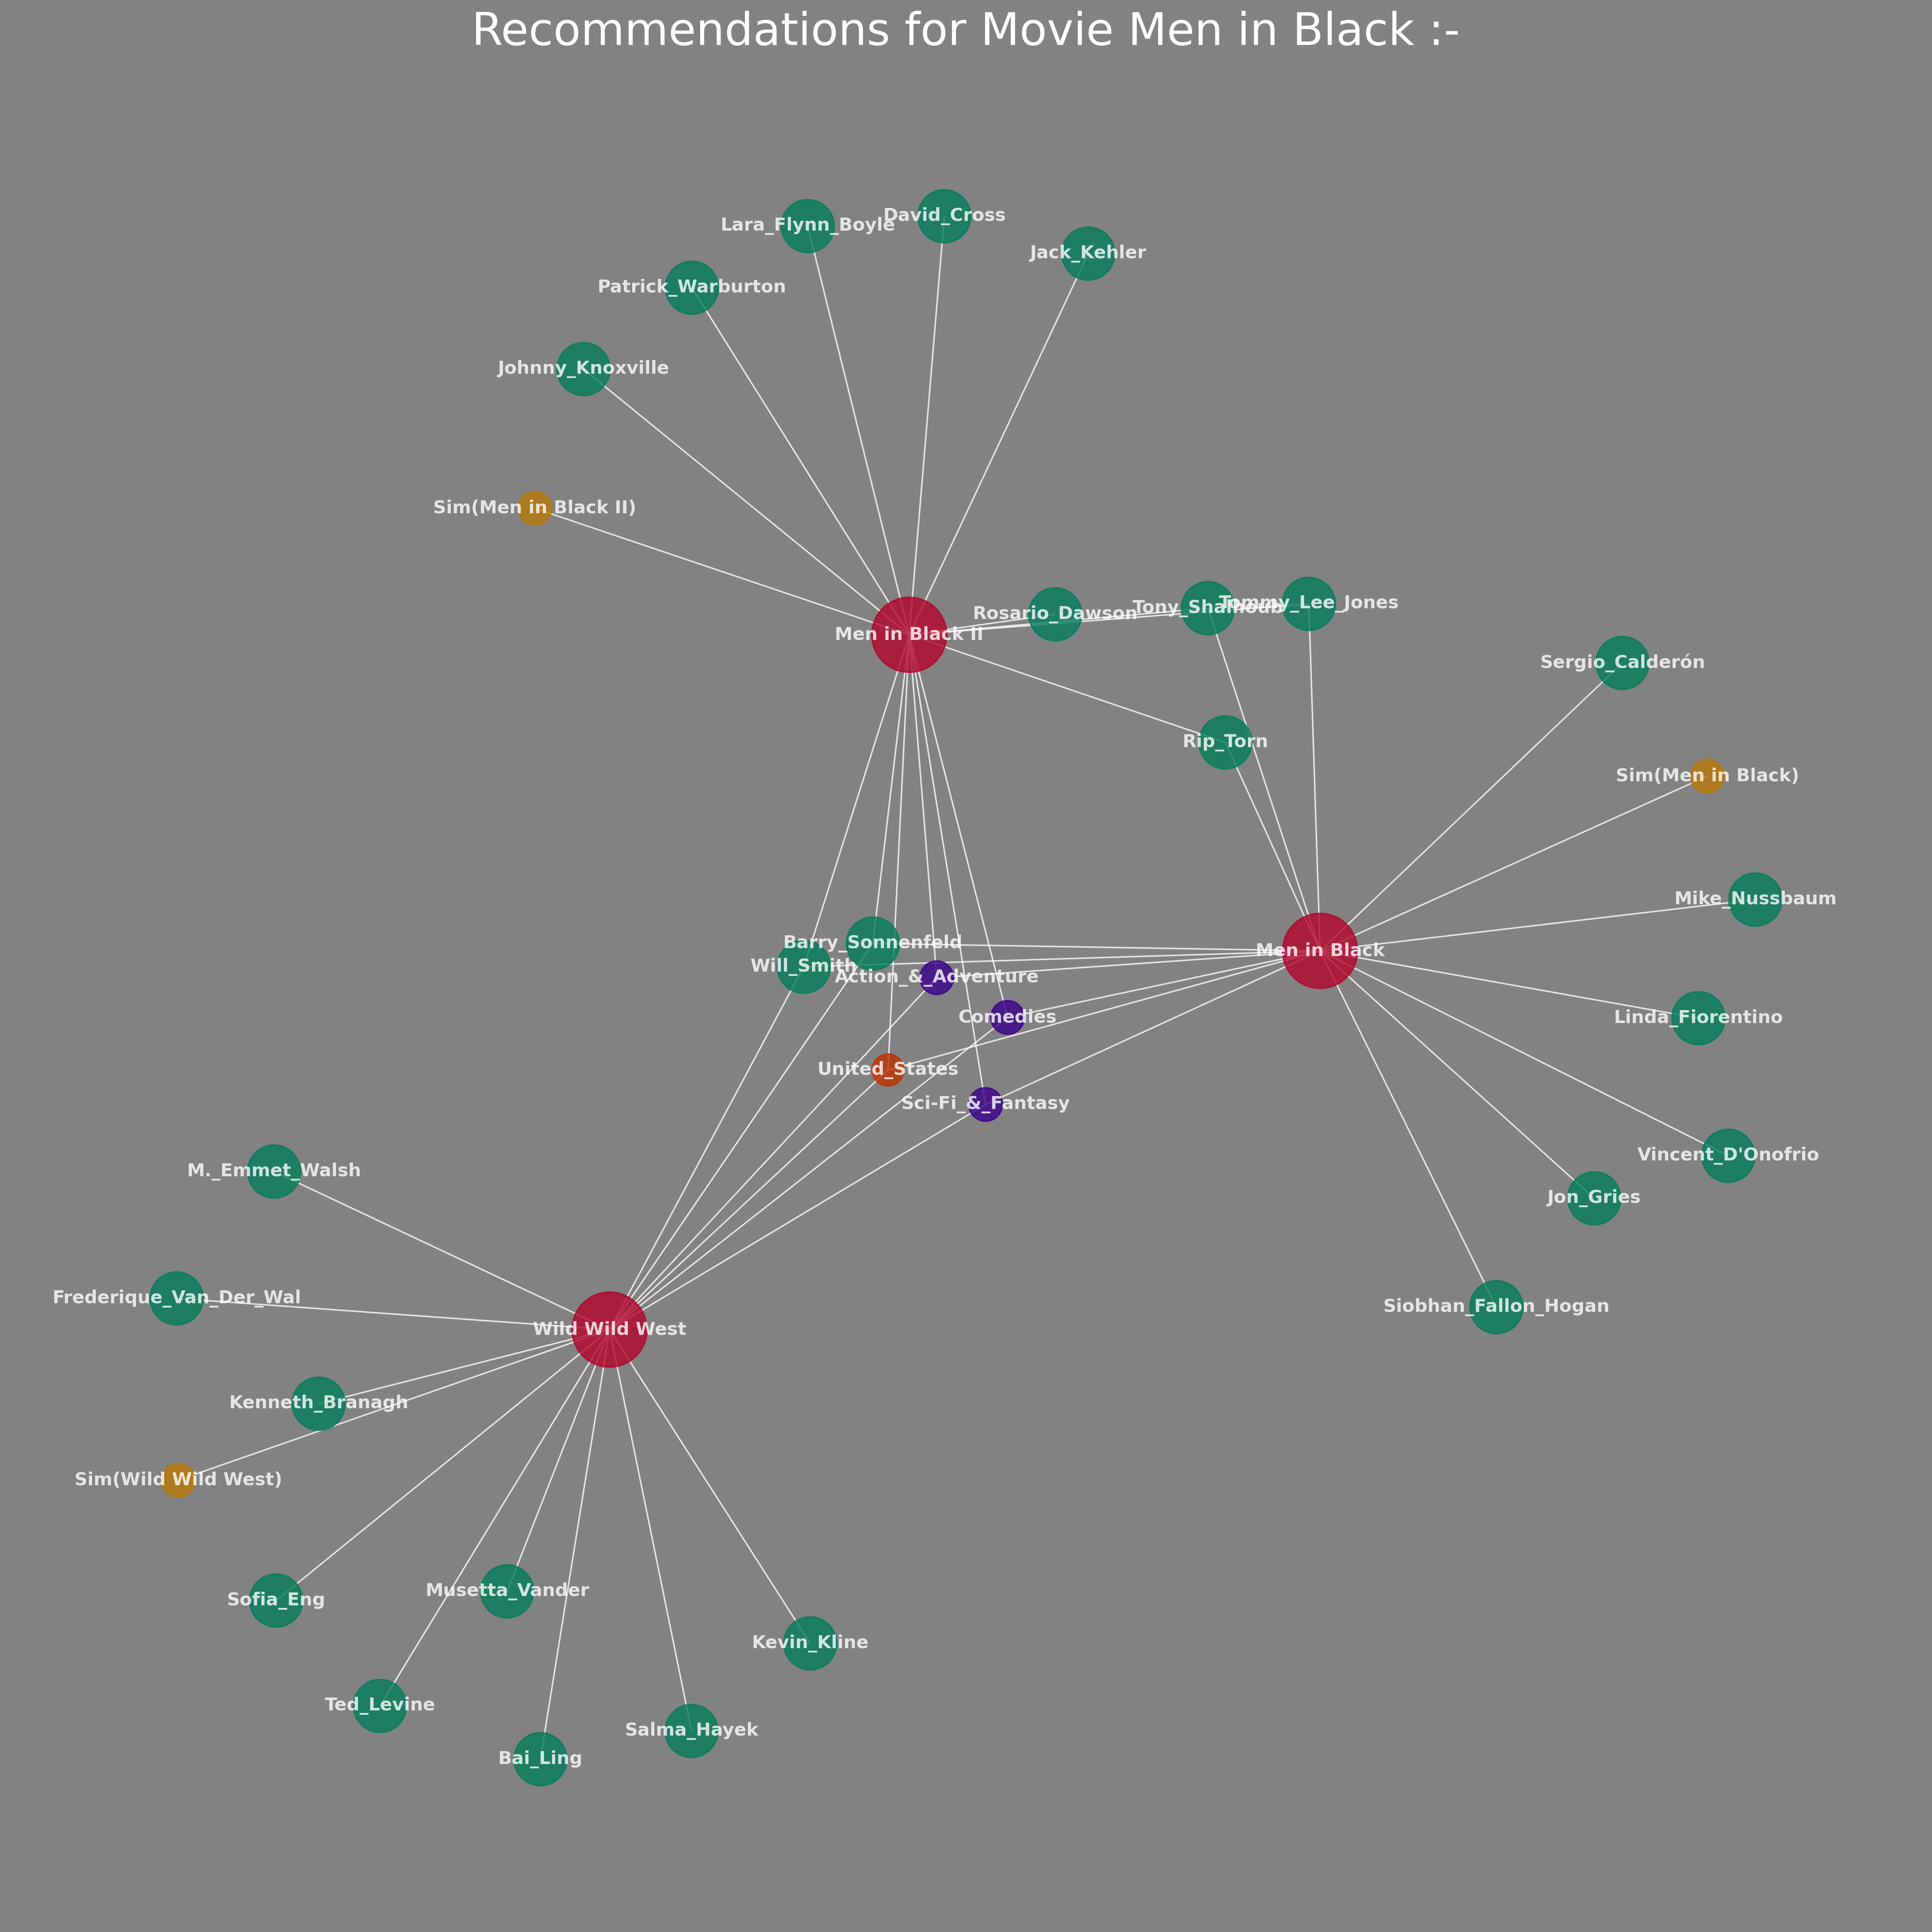

In [28]:
recommendation = get_recommendation(selected_movie)
rel_graph = get_all_adj_nodes([selected_movie] + list(recommendation.index[:2]))
draw_sub_graph(rel_graph, selected_movie)
